# Generate preliminary plots and utility matrices

In [1]:
import pandas as pd
import numpy as np

import os
import datetime
from datetime import date, timedelta
from tqdm import tqdm_notebook
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools

from scipy.optimize import curve_fit

data_path = os.path.join('/','home','fterroso','data','Spain-INE-mobility-study-2020')

#Covered period of study
e_date = datetime.datetime.strptime('2020-11-30', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-02-20', '%Y-%m-%d')

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/home/fterroso/python/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## General functions

In [2]:
def generate_days_fn(init_date, final_date):
    
    delta = final_date - init_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [7]:
def read_INE_trips_date_fn(date_, trips_type='all'):
    date_str= date_.strftime('%Y%m%d')
    df_date= pd.read_csv(os.path.join(data_path, 'muestra1', f'{date_str}_maestra_1_mitma_distrito.txt'), 
                             sep='|',dtype={'origen':str, 'destino':str,'fecha':str, 'periodo':str})
    
    if trips_type=='inter':
        df_date= df_date[df_date['origen']!=df_date['destino']] #only keep trips between areas
    elif trips_type=='intra':
        df_date= df_date[df_date['origen']==df_date['destino']] #only keep trips within the areas
    
    #convert period column to a two-digit string
    df_date['periodo'] = df_date['periodo'].apply(lambda x: x.zfill(2))
    df_date= df_date.fillna(0) # set nan as 0
    return df_date

## Distance distribution

In [4]:
def generate_distance_distribution(from_date, to_date, trips_type='all'):
    
    result_df = None
    time_series = []
    target_days = generate_days_fn(from_date, to_date)
    for date in tqdm_notebook(target_days):
        df = read_INE_trips_date_fn(date, trips_type)
        dist_df= df.groupby('distancia').size().to_frame()
        if result_df is None:
            result_df = dist_df
        else:
            result_df = result_df + dist_df
    return result_df

In [5]:
#trip_distance_df = generate_distance_distribution(datetime.datetime.strptime('2020-02-21', '%Y-%m-%d'),
#                     datetime.datetime.strptime('2020-11-30', '%Y-%m-%d'),trips_type='inter')
#trip_distance_df.plot(kind='bar',grid=True,logy=True);
#trip_distance_df.to_csv(os.path.join('data','trip_distance_inter.csv'))

## Plot evolution number of trips

In [6]:
def add_total_values_fn(trips_df_):
    trips_df_['total'] = trips_df_.sum(axis=1) # column with total number of trips per area
    trips_df_.loc['total'] = trips_df_.sum(axis=0) # row with total number of trips per day
    return trips_df_

In [7]:
inter_trips = pd.read_csv(os.path.join('data','trips_time_series_all_inter.csv'),index_col=0)
inter_trips= inter_trips.fillna(0)

In [8]:
inter_trips = add_total_values_fn(inter_trips)

In [9]:
inter_trips.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23,total
01001_AM,291.654,129.650,123.822,280.810,282.418,518.179,736.074,1253.000,981.544,893.510,...,1026.083,1073.847,1147.206,650.740,648.024,563.314,735.201,258.461,230.591,4189691.344
01002,192.529,149.992,50.547,73.097,208.114,616.786,732.075,779.587,638.112,734.767,...,598.760,615.822,826.882,580.843,378.512,381.695,407.566,124.729,106.744,2441188.659
01010_AM,92.726,50.822,37.895,19.586,91.560,396.531,457.180,591.326,516.919,471.008,...,610.121,559.796,476.880,354.807,215.711,216.593,277.574,119.830,52.331,1988351.484
01031_AM,97.674,64.901,92.150,62.669,109.056,208.462,469.924,691.565,645.793,789.906,...,628.526,682.578,582.456,603.958,344.157,286.541,269.655,159.443,118.029,3330112.565
01036,173.565,118.227,204.784,219.318,409.485,779.103,1091.613,969.506,845.084,875.701,...,815.612,681.116,746.917,704.784,413.711,441.988,575.437,319.760,68.968,3408282.950


In [10]:
inter_trips.tail()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23,total
05220_AM,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.975651e+05
40149_AM,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.470990e+04
31092_AM,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,263.079,312.210,233.029,58.550,178.702,64.342,9.760,11.840,0.000,8.443220e+05
20903,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.786355e+05
total,1684916.941,1226649.105,1042022.789,1060856.35,1416676.085,2260724.424,3464423.098,5400817.701,5740627.237,5047932.524,...,5060517.688,4719101.508,4925188.213,4992998.135,4451594.013,3834109.629,3071823.504,2149818.919,1210790.486,2.021387e+10


In [11]:
intra_trips = pd.read_csv(os.path.join('data','trips_time_series_all_intra.csv'),index_col=0)
intra_trips= intra_trips.fillna(0)
intra_trips = add_total_values_fn(intra_trips)

In [12]:
intra_trips.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23,total
01001_AM,59.915,22.328,46.492,24.098,83.646,93.864,56.448,94.836,96.838,190.334,...,197.260,195.845,117.577,175.307,94.397,110.305,113.574,89.900,108.185,957751.063
01002,115.028,149.517,184.043,46.011,194.751,159.942,168.706,254.343,256.654,353.640,...,439.049,354.764,462.380,494.522,401.619,333.450,324.661,328.207,142.446,1878064.363
01010_AM,24.950,23.959,36.027,13.548,24.950,33.607,19.249,38.972,35.626,46.011,...,46.824,22.506,60.091,78.379,90.224,85.874,42.784,80.194,27.482,384773.459
01031_AM,27.274,42.707,18.797,19.768,41.285,14.286,71.247,224.269,127.676,117.224,...,228.601,140.950,202.339,89.877,102.807,68.622,52.335,7.333,25.801,702636.249
01036,341.762,114.641,167.959,217.580,176.934,287.099,497.392,478.965,575.706,811.725,...,569.517,738.954,711.274,807.784,857.207,750.512,387.753,429.239,238.795,3552633.749


In [13]:
intra_trips.tail()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23,total
12021,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.662710e+02
20903,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.970274e+04
41010,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.020940e+02
30010,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.941000e+00
total,849409.285,607856.302,478447.49,437609.182,499382.674,694471.622,945354.035,1467740.739,1842706.03,1860840.869,...,1928603.514,1846993.276,1953474.502,2072962.618,1973373.269,1784314.375,1522351.289,1201464.861,777018.902,8.662693e+09


In [14]:
all_trips_day = pd.read_csv(os.path.join('data','trips_time_series_all_day.csv'),index_col=0)
all_trips_day= all_trips_day.fillna(0)
all_trips_day = add_total_values_fn(all_trips_day)

In [15]:
all_trips_day.head()

,20200221,20200222,20200223,20200224,20200225,20200226,20200227,20200228,20200229,20200301,...,20201122,20201123,20201124,20201125,20201126,20201127,20201128,20201129,20201130,total
01001_AM,20581.269,18398.675,17941.785,21104.670,20120.396,20169.324,20510.287,22399.406,17315.949,16017.099,...,13900.657,18814.524,20811.172,19107.189,20935.104,19484.587,16719.054,14842.081,19977.788,5147442.407
01002,19954.317,16526.047,13262.583,19511.322,19517.378,20356.894,19677.363,20850.850,16045.034,14371.868,...,13647.278,14735.933,19431.647,18610.034,18217.208,17636.659,11852.999,10488.448,17391.825,4319253.022
01010_AM,11734.532,9202.304,7573.631,9831.776,9983.023,10516.394,10516.592,11270.468,9317.748,8071.942,...,6544.801,9016.833,10544.730,9033.079,9533.074,9048.726,6844.107,5253.775,9260.783,2373124.943
01031_AM,17830.597,15459.462,14138.051,16269.965,17134.141,16883.402,17573.834,18689.533,18634.240,15601.253,...,7614.277,13710.568,12571.361,13466.602,12338.549,12045.516,8246.424,7358.908,12484.364,4032748.814
01036,35213.752,26945.043,25220.010,30679.608,31580.617,32973.612,33610.879,33451.099,26792.829,21889.661,...,17093.973,27979.181,28007.641,29804.730,29776.753,26945.496,19665.304,14584.672,25658.845,6960916.699


In [16]:
all_trips_day.tail()

,20200221,20200222,20200223,20200224,20200225,20200226,20200227,20200228,20200229,20200301,...,20201122,20201123,20201124,20201125,20201126,20201127,20201128,20201129,20201130,total
05220_AM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.092883e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.029233e+05
40149_AM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000625e+04
31092_AM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.925233e+03,3.561340e+03,3.603525e+03,4.563067e+03,4.597447e+03,4.630050e+03,5.021346e+03,7.857952e+03,5.086319e+03,1.498084e+06
20903,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.983382e+05
total,1.411940e+08,1.151317e+08,1.017364e+08,1.321131e+08,1.328624e+08,1.369374e+08,1.389711e+08,1.342742e+08,1.137585e+08,1.000604e+08,...,7.905046e+07,1.159803e+08,1.174942e+08,1.167364e+08,1.153765e+08,1.168420e+08,9.290070e+07,7.888559e+07,1.157682e+08,2.887656e+10


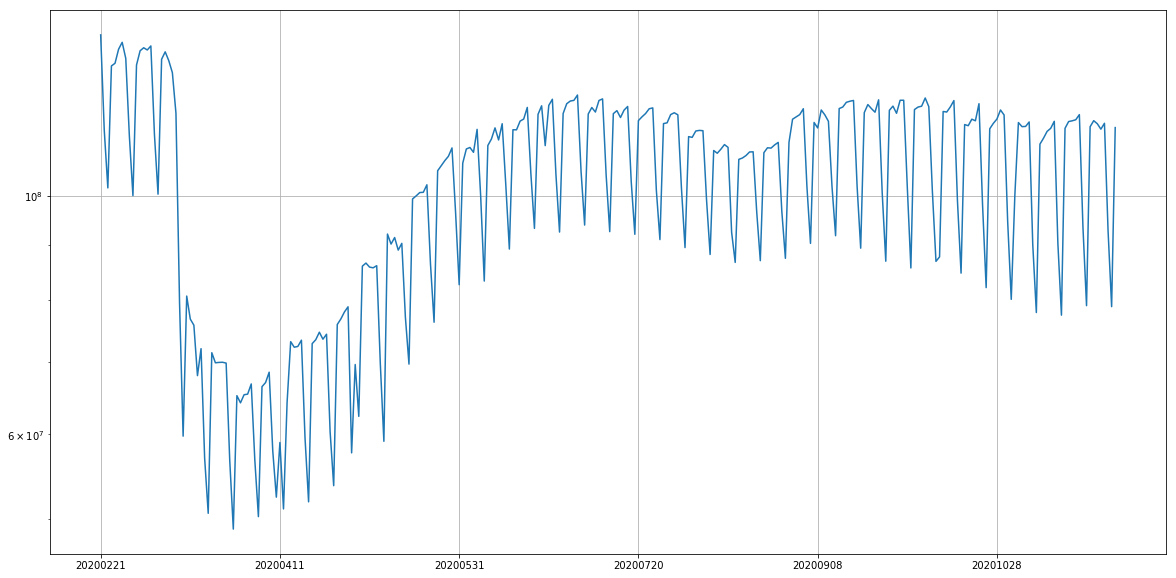

In [17]:
ax= all_trips_day.drop(columns='total').loc['total'].plot(figsize=(20,10),grid=True, logy=True)


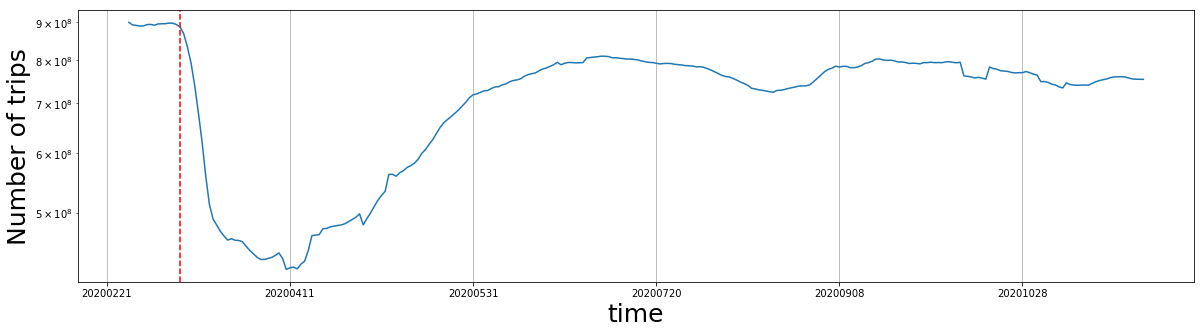

In [18]:
ax= all_trips_day.drop(columns='total').loc['total'].rolling(7).sum().plot(figsize=(20,5), grid=True,logy=True);
ax.axvline(20,color='r',linestyle='--',label='Center')
ax.set_ylabel('Number of trips')
ax.set_xlabel('time')
ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
plt.savefig(os.path.join('figs','trips_evolution.png'))

## Map with total number of trips

In [19]:
zones_gdf = gpd.read_file(os.path.join(data_path,'zonificacion','distritos_mitma.shp'))
zones_gdf = zones_gdf.set_index('ID')

In [20]:
zones_gdf.crs

<Projected CRS: EPSG:3042>
Name: ETRS89 / UTM zone 30N (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - 6°W to 0°W and ETRS89 by country
- bounds: (-6.0, 35.26, 0.0, 80.53)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
zones_gdf.head()

,geometry
ID,
2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4..."
22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4..."
2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4..."
07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088..."
2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4..."


In [22]:
all_trips = pd.read_csv(os.path.join('data','trips_time_series_all.csv'),index_col=0)
all_trips= all_trips.fillna(0)
all_trips = add_total_values_fn(all_trips)

In [23]:
all_trips.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23,total
01001_AM,351.569,151.978,170.314,304.908,366.064,612.043,792.522,1347.836,1078.382,1083.844,...,1223.343,1269.692,1264.783,826.047,742.421,673.619,848.775,348.361,338.776,5147442.407
01002,307.557,299.509,234.590,119.108,402.865,776.728,900.781,1033.930,894.766,1088.407,...,1037.809,970.586,1289.262,1075.365,780.131,715.145,732.227,452.936,249.190,4319253.022
01010_AM,117.676,74.781,73.922,33.134,116.510,430.138,476.429,630.298,552.545,517.019,...,656.945,582.302,536.971,433.186,305.935,302.467,320.358,200.024,79.813,2373124.943
01031_AM,124.948,107.608,110.947,82.437,150.341,222.748,541.171,915.834,773.469,907.130,...,857.127,823.528,784.795,693.835,446.964,355.163,321.990,166.776,143.830,4032748.814
01036,515.327,232.868,372.743,436.898,586.419,1066.202,1589.005,1448.471,1420.790,1687.426,...,1385.129,1420.070,1458.191,1512.568,1270.918,1192.500,963.190,748.999,307.763,6960916.699


In [24]:
zones_gdf['n_trips']= all_trips['total']

In [25]:
zones_gdf.head()

,geometry,n_trips
ID,,
2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4...",6020624.818
22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4...",2623196.900
2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4...",3778178.501
07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088...",4161969.734
2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4...",4798684.013


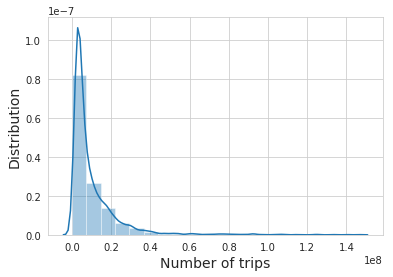

In [26]:
sns.set_style("whitegrid")
ax = sns.distplot(zones_gdf['n_trips'], bins=20, rug=False);
ax.set_ylabel('Distribution')
ax.set_xlabel('Number of trips')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.savefig(os.path.join('figs','trips_per_area.png'))

In [27]:
zones_gdf['n_trips'].describe()

count    2.844000e+03
mean     1.015350e+07
std      1.336878e+07
min      5.894622e+03
25%      2.960561e+06
50%      5.422956e+06
75%      1.228605e+07
max      1.464161e+08
Name: n_trips, dtype: float64

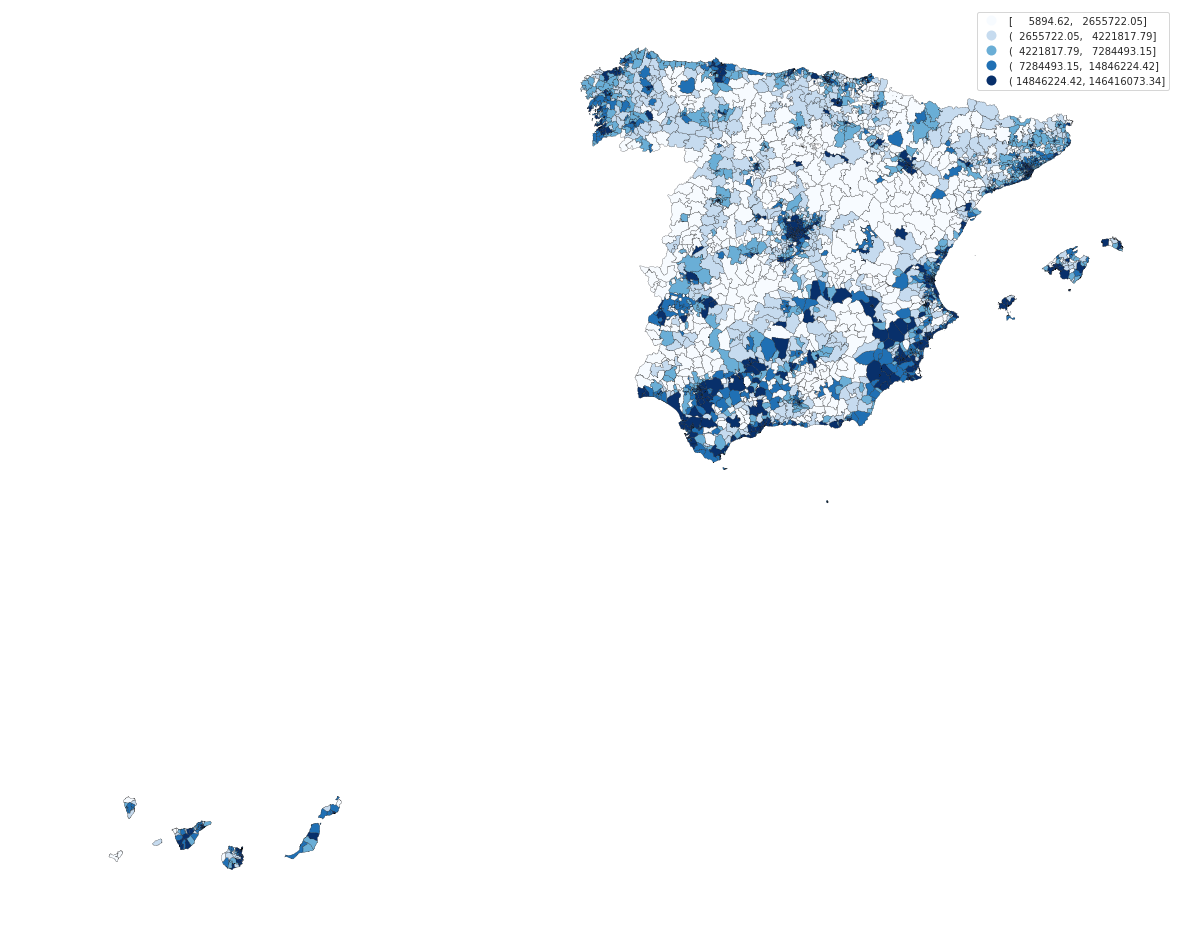

In [28]:
ax= zones_gdf.plot(column='n_trips',
                   figsize=(20,20),
                   scheme='Quantiles',
                   legend=True, 
                   cmap='Blues',
                   edgecolor='k', 
                   linewidth=0.2)
ax.set_axis_off()
plt.savefig(os.path.join('figs','n_total_trips.png'))

# Distribution of the zones size

In [29]:
zones_gdf['area_size']= zones_gdf['geometry'].apply(lambda x: x.area)

In [30]:
zones_gdf.head()

,geometry,n_trips,area_size
ID,,,
2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4...",6020624.818,2.051529e+06
22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4...",2623196.900,5.194906e+08
2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4...",3778178.501,2.370956e+07
07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088...",4161969.734,2.287712e+08
2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4...",4798684.013,6.159173e+06


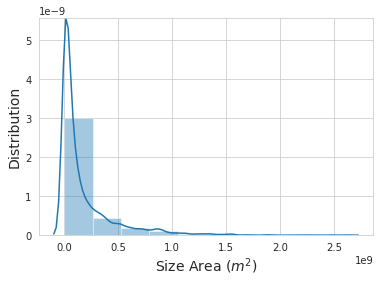

In [31]:
sns.set_style("whitegrid")
ax=sns.distplot(zones_gdf['area_size'], bins=10, rug=False);
ax.set_ylabel('Distribution')
ax.set_xlabel('Size Area ($m^2$)')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.savefig(os.path.join('figs','size_per_area.png'))

## Add population to MAs

In [33]:
zones_gdf = gpd.read_file(os.path.join(data_path,'zonificacion','distritos_mitma.shp'))
zones_gdf = zones_gdf.to_crs({'init': 'epsg:3857'}) 
zones_gdf['area']= zones_gdf['geometry'].apply(lambda x: x.area)

/home/fterroso/python/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Get data from other study with MA and population data

In [34]:
data_path_ = '/home/fterroso/data/'
celdas_gdf = gpd.read_file(data_path_ + 'Spain-mobility-areas/celdas_marzo_2020.shp', encoding='UTF-8')
celdas_gdf['area']= celdas_gdf['geometry'].apply(lambda x: x.area)
celdas_gdf = celdas_gdf[['ID_GRUPO','SUM_POB_AS', 'area','geometry']]

In [35]:
res_intersection = gpd.overlay(zones_gdf, celdas_gdf, how='intersection')
res_intersection['area'] = res_intersection['geometry'].apply(lambda x: x.area)
res_intersection['overlap'] = res_intersection['area'] / res_intersection['area_2']

We only keep intersection with a 95% of overlaping

In [36]:
res_intersection= res_intersection[res_intersection['overlap']>0.95]

In [37]:
res_intersection.head()

,ID,area_1,ID_GRUPO,SUM_POB_AS,area_2,geometry,area,overlap
7,2408908_AD,3.759496e+07,06LE,5714.0,3.757911e+07,"POLYGON ((-619834.812 5247207.568, -619760.395...",3.752145e+07,0.998466
15,24222,9.742087e+07,41LE,15841.0,9.746183e+07,"POLYGON ((-614972.224 5253754.372, -614949.309...",9.735795e+07,0.998934
20,2408904,4.215699e+06,45LE,16082.0,4.220575e+06,"POLYGON ((-619926.737 5251048.347, -619926.740...",4.203981e+06,0.996068
25,2408905,1.767941e+06,46LE,11386.0,1.769321e+06,"POLYGON ((-619530.981 5250058.299, -619530.981...",1.757528e+06,0.993335
29,2408910,3.787154e+06,49LE,7913.0,3.783858e+06,"POLYGON ((-617620.363 5250652.171, -617588.265...",3.769651e+06,0.996245


In [38]:
ma_populations_df= res_intersection.groupby('ID').sum('SUM_POB_AS')

In [39]:
ma_populations_df.head()

,area_1,SUM_POB_AS,area_2,area,overlap
ID,,,,,
01001_AM,6.676339e+08,6400.0,6.676679e+08,6.671781e+08,0.999266
01002,1.799148e+08,8875.0,1.799114e+08,1.796525e+08,0.998561
01010_AM,3.730790e+08,5056.0,3.730847e+08,3.727557e+08,0.999118
01031_AM,6.785925e+08,6505.0,6.787582e+08,6.781534e+08,0.999109
01036,7.028990e+07,16083.0,7.034920e+07,7.022879e+07,0.998288


In [40]:
zones_gdf = zones_gdf.set_index('ID')

In [41]:
zones_gdf['POPULATION']= ma_populations_df['SUM_POB_AS']

In [42]:
zones_gdf.head()

,geometry,area,POPULATION
ID,,,
2408910,"POLYGON ((-617620.363 5250652.172, -617588.265...",3.787154e+06,7913.0
22117_AM,"POLYGON ((34933.242 5170510.672, 35245.027 516...",9.454305e+08,4735.0
2305009,"POLYGON ((-422751.792 4546198.978, -422786.882...",3.800710e+07,6438.0
07058_AM,"POLYGON ((316538.056 4827970.183, 316275.800 4...",3.860436e+08,5526.0
2305006,"POLYGON ((-422698.978 4547443.296, -422616.243...",9.881060e+06,6088.0


In [45]:
zones_gdf.shape

(2850, 3)

In [44]:
zones_gdf.to_file(os.path.join('data','distritos_mitma_pop.geojson'), driver='GeoJSON')

# Generate distance matrix among MAs

In [11]:
zones_gdf = gpd.read_file(os.path.join(data_path,'zonificacion','distritos_mitma.shp'))

In [12]:
zones_id = zones_gdf['ID'].unique().tolist()

In [13]:
distances_df = pd.DataFrame(0,columns=zones_id, index=zones_id)

In [14]:
for o_ma, d_ma in tqdm_notebook(itertools.combinations(zones_id, r=2)):                    
    o_centroid = zones_gdf[zones_gdf['ID']==o_ma]['geometry'].iloc[0].centroid
    d_centroid = zones_gdf[zones_gdf['ID']==d_ma]['geometry'].iloc[0].centroid
    dist = o_centroid.distance(d_centroid)/1000
    distances_df.loc[o_ma, d_ma]= dist
    distances_df.loc[d_ma,o_ma]= dist

KeyboardInterrupt: 

In [ ]:
distances_df.head()

In [ ]:
distances_df.to_csv(os.path.join('data', 'distances.csv'))

## Generate Gravity-model adjacency matrix

In [3]:
distances_df = pd.read_csv(os.path.join('data', 'distances.csv'), index_col=0)

In [4]:
distances_df.head()

,2408910,22117_AM,2305009,07058_AM,2305006,2305005,2305004,2305003,2305002,2305001,...,15073,1303404,15071,02045_AM,43176_AM,31010_AM,08016_AM,45037_AM,06050_AM,50182
2408910,0.000000,486.440732,559.017070,770.318326,555.642978,546.158165,547.910976,552.134341,560.933730,567.548867,...,284.132991,424.303963,282.148286,496.807994,565.553071,276.590753,605.835768,314.437855,498.882300,384.148841
22117_AM,486.440732,0.000000,605.520597,338.549989,603.288019,594.688101,590.743474,590.333038,602.583862,608.233923,...,770.338560,503.833978,768.583241,374.442088,113.367012,222.629906,120.245756,478.804162,738.606151,136.839469
2305009,559.017070,605.520597,0.000000,623.178521,3.374364,13.275861,14.918798,15.667594,5.853712,9.352433,...,695.956569,138.191743,703.953789,242.025450,575.160704,588.320498,684.938604,244.635736,251.250360,484.310784
07058_AM,770.318326,338.549989,623.178521,0.000000,622.624814,618.090533,611.782926,608.289260,618.001762,620.743928,...,1041.521790,590.211391,1042.541502,401.004944,226.705112,545.040383,277.592598,629.540216,840.121025,389.386535
2305006,555.642978,603.288019,3.374364,622.624814,0.000000,10.025771,12.552679,14.423026,7.611074,12.490407,...,692.869269,134.874955,700.848327,240.456545,573.433904,585.316556,683.081726,241.261392,249.784481,481.797876


In [5]:
distances_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2850 entries, 2408910 to 50182
Columns: 2850 entries, 2408910 to 50182
dtypes: float64(2850)
memory usage: 62.0+ MB


In [6]:
zones_gdf= gpd.read_file(os.path.join('data','distritos_mitma_pop.geojson'), driver='GeoJSON')
zones_gdf = zones_gdf.set_index('ID')

In [7]:
zones_gdf.head()

,area,POPULATION,geometry
ID,,,
2408910,3.787154e+06,7913.0,"POLYGON ((-617620.363 5250652.172, -617588.265..."
22117_AM,9.454305e+08,4735.0,"POLYGON ((34933.242 5170510.672, 35245.027 516..."
2305009,3.800710e+07,6438.0,"POLYGON ((-422751.792 4546198.978, -422786.882..."
07058_AM,3.860436e+08,5526.0,"POLYGON ((316538.056 4827970.183, 316275.800 4..."
2305006,9.881060e+06,6088.0,"POLYGON ((-422698.978 4547443.296, -422616.243..."


In [8]:
zones_gdf= zones_gdf.fillna(0.0)

In [9]:
is_NaN = zones_gdf.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = zones_gdf[row_has_NaN]

In [10]:
rows_with_NaN

,area,POPULATION,geometry
ID,,,


In [11]:
zones_gdf['POPULATION'].isnull().values.any()

False

In [12]:
zones_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2850 entries, 2408910 to 50182
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   area        2850 non-null   float64 
 1   POPULATION  2850 non-null   float64 
 2   geometry    2850 non-null   geometry
dtypes: float64(2), geometry(1)
memory usage: 89.1+ KB


In [13]:
grav_model_adj_matrix = pd.DataFrame(0, index=distances_df.index, columns=distances_df.index.values)

In [14]:
zones_id =distances_df.index.tolist()

In [15]:
for o_ma, d_ma in tqdm_notebook(itertools.combinations(zones_id, r=2)):  
    d = distances_df.loc[o_ma,d_ma]
    pop_o = zones_gdf.loc[o_ma, 'POPULATION']
    pop_d = zones_gdf.loc[d_ma, 'POPULATION']
    n_trips = (pop_o * pop_d)/d
    grav_model_adj_matrix.loc[o_ma, d_ma] = n_trips
    grav_model_adj_matrix.loc[d_ma, o_ma] = n_trips

KeyboardInterrupt: 

In [ ]:
grav_model_adj_matrix.head()

In [ ]:
grav_model_adj_matrix.info()

There is not Nan values in the matrix

In [ ]:
grav_model_adj_matrix.isnull().values.any()

In [ ]:
grav_model_adj_matrix.to_csv(os.path.join('data','gravity_model_adjacency_matrix.csv'))

## Generate distance vs number of trips plot

In [16]:
distances_df = pd.read_csv(os.path.join('data', 'distances.csv'), index_col=0)

In [17]:
distances_df.head()

,2408910,22117_AM,2305009,07058_AM,2305006,2305005,2305004,2305003,2305002,2305001,...,15073,1303404,15071,02045_AM,43176_AM,31010_AM,08016_AM,45037_AM,06050_AM,50182
2408910,0.000000,486.440732,559.017070,770.318326,555.642978,546.158165,547.910976,552.134341,560.933730,567.548867,...,284.132991,424.303963,282.148286,496.807994,565.553071,276.590753,605.835768,314.437855,498.882300,384.148841
22117_AM,486.440732,0.000000,605.520597,338.549989,603.288019,594.688101,590.743474,590.333038,602.583862,608.233923,...,770.338560,503.833978,768.583241,374.442088,113.367012,222.629906,120.245756,478.804162,738.606151,136.839469
2305009,559.017070,605.520597,0.000000,623.178521,3.374364,13.275861,14.918798,15.667594,5.853712,9.352433,...,695.956569,138.191743,703.953789,242.025450,575.160704,588.320498,684.938604,244.635736,251.250360,484.310784
07058_AM,770.318326,338.549989,623.178521,0.000000,622.624814,618.090533,611.782926,608.289260,618.001762,620.743928,...,1041.521790,590.211391,1042.541502,401.004944,226.705112,545.040383,277.592598,629.540216,840.121025,389.386535
2305006,555.642978,603.288019,3.374364,622.624814,0.000000,10.025771,12.552679,14.423026,7.611074,12.490407,...,692.869269,134.874955,700.848327,240.456545,573.433904,585.316556,683.081726,241.261392,249.784481,481.797876


In [18]:
e_date = datetime.datetime.strptime('2020-02-29', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-02-21', '%Y-%m-%d')

In [19]:
target_days = generate_days_fn(i_date, e_date)
sum_od= None
for date in tqdm_notebook(target_days):
    od= pd.read_csv(os.path.join('data', 'OD', 'od_matrix_{}'.format(date.strftime("%Y-%m-%d"))), index_col=0)
    if sum_od is not None:
        sum_od = sum_od.add(od, fill_value=0)
    else:
        sum_od= od

In [20]:
sum_od.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,0105901,...,5100105,5100106,5200101_AD,5200102,5200104,5200105,5200106,5200107,5200108,total
origen,,,,,,,,,,,,,,,,,,,,,
01001_AM,26533.352,220.408,113.594,302.246,462.437,3269.559,315.147,24540.871,5667.620,8517.671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178541.761
01002,191.282,64277.173,22492.869,140.837,24926.980,69.504,239.956,48.765,482.097,569.374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165701.788
01010_AM,167.575,23115.419,12434.012,0.000,14931.230,6.774,190.646,73.730,237.460,271.959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89946.468
01031_AM,275.287,120.781,25.625,27615.898,136.919,12521.806,3394.359,63.178,310.660,1454.228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152613.225
01036,440.468,24849.925,15118.484,157.114,132670.078,68.098,206.751,50.717,296.485,535.547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276467.449


In [21]:
sum_od_stacked= sum_od.stack().to_frame().rename(columns={0:'num_trips'})

In [22]:
distances_stacked= distances_df.stack().to_frame().rename(columns={0:'distance'})

In [23]:
distances_stacked.head()

distance
2408910 2408910     0.000000
        22117_AM  486.440732
        2305009   559.017070
        07058_AM  770.318326
        2305006   555.642978

In [24]:
sum_od_stacked['distance']=distances_stacked['distance']

In [25]:
sum_od_stacked = sum_od_stacked[sum_od_stacked['distance']>0]

In [26]:
sum_od_stacked.head()

num_trips   distance
origen                                 
01001_AM 01002       220.408  46.607889
         01010_AM    113.594  57.622506
         01031_AM    302.246  37.306976
         01036       462.437  52.641754
         01043_AM   3269.559  22.761490

In [27]:
sum_od_stacked.shape

(8062748, 2)

In [28]:
df = sum_od_stacked.sample(10000)

In [29]:
df= df.sort_values(by='distance')

In [30]:
df= df.dropna()

In [31]:
df = df[(df['distance']>0) & (df['num_trips']>0)]

In [32]:
x= df['distance'].values
y= df['num_trips'].values
xlog= np.log(x)
ylog= np.log(y)

In [33]:
def fitfunc(x,p1,p2,p3):
    y = p1+(x*p2)+((x**2)*p3)
    return y

In [34]:
t_function = fitfunc

In [35]:
#popt, pcov = curve_fit(t_function, x, y)
popt, pcov = curve_fit(t_function, np.log10(x), np.log10(y))

In [36]:
a,b,c= popt
a = round(a,2)
b = round(b,2)
c = round(c,2)

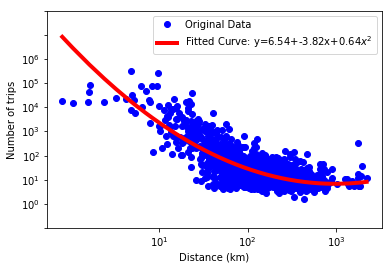

In [37]:
plt.plot(np.log10(x), np.log10(y), 'ko', label="Original Data", color='blue');
plt.plot(np.log10(x), t_function(np.log10(x), *popt), 'r-', label=f"Fitted Curve: y={a}+{b}x+{c}$x^2$", linewidth=4)
new_loc= [1, 2, 3]
new_labels= ['$10^1$', '$10^2$','$10^3$']
plt.xticks(new_loc,new_labels)
locy, labels = plt.yticks()
new_labels_y= ['','$10^0$', '$10^1$', '$10^2$','$10^3$','$10^4$','$10^5$','$10^6$'] 
plt.yticks(locy,new_labels_y)

plt.ylabel('Number of trips')
plt.xlabel('Distance (km)')
plt.legend()
#plt.show()
plt.savefig(os.path.join('figs','distance-vs-num_trips_w_params.png'))

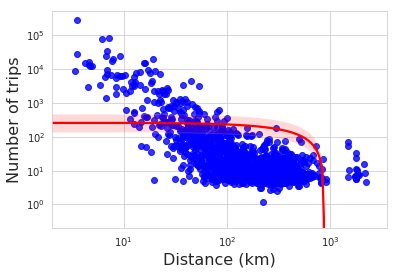

In [38]:
sns.set_style("whitegrid")
ax=sns.regplot(x='distance', y='num_trips', data=sum_od_stacked.sample(10000), fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
ax.set(xscale="log", yscale="log")
ax.set_ylabel('Number of trips')
ax.set_xlabel('Distance (km)')
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.savefig(os.path.join('figs','distance-vs-num_trips.png'))

## Plot number of connections per MA

In [39]:
sum_od.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,0105901,...,5100105,5100106,5200101_AD,5200102,5200104,5200105,5200106,5200107,5200108,total
origen,,,,,,,,,,,,,,,,,,,,,
01001_AM,26533.352,220.408,113.594,302.246,462.437,3269.559,315.147,24540.871,5667.620,8517.671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178541.761
01002,191.282,64277.173,22492.869,140.837,24926.980,69.504,239.956,48.765,482.097,569.374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165701.788
01010_AM,167.575,23115.419,12434.012,0.000,14931.230,6.774,190.646,73.730,237.460,271.959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89946.468
01031_AM,275.287,120.781,25.625,27615.898,136.919,12521.806,3394.359,63.178,310.660,1454.228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152613.225
01036,440.468,24849.925,15118.484,157.114,132670.078,68.098,206.751,50.717,296.485,535.547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276467.449


In [40]:
sum_od.tail()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,0105901,...,5100105,5100106,5200101_AD,5200102,5200104,5200105,5200106,5200107,5200108,total
origen,,,,,,,,,,,,,,,,,,,,,
5200105,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,...,0.000,0.000,20167.458,20162.333,25332.816,32606.678,35036.008,50028.937,117725.435,3.025089e+05
5200106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,...,0.000,0.000,14721.088,10149.806,27708.109,35930.517,7873.217,42906.465,69593.450,2.097595e+05
5200107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,...,0.000,0.000,18640.681,31777.667,36271.680,51485.397,39514.317,29197.074,131546.141,3.395301e+05
5200108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,...,0.000,0.000,47826.319,59595.037,94688.052,119018.418,67310.347,135006.565,262734.387,7.896133e+05
total,175506.305,165472.923,89034.451,153943.209,275964.617,133612.956,102291.491,79910.139,167553.101,1013862.21,...,206471.507,356560.868,130986.634,153418.009,225305.075,309253.832,202319.559,345634.357,783922.155,1.146979e+09


In [63]:
def generate_avg_n_origin_destinations_fn(od_, trip_rate_threshold):
    norm_od_global = od_.div(od_['total'], axis=0)
    norm_od_global['n_meaningful_dest'] = norm_od_global.apply(lambda row: row[row>trip_rate_threshold].shape[0], axis=1)
    
    trasnsposed_norm_od= norm_od_global.T
    trasnsposed_norm_od['n_meaningful_dest'] = trasnsposed_norm_od.apply(lambda row: row[row>trip_rate_threshold].shape[0], axis=1)
    
    norm_od_global['type'] = 'destination'
    trasnsposed_norm_od['type'] = 'origin'
    
    df = pd.concat([trasnsposed_norm_od['n_meaningful_dest type'.split()],
                norm_od_global['n_meaningful_dest type'.split()]], axis=0)
    
    #df['source']= source
    
    return df

In [64]:
connections =generate_avg_n_origin_destinations_fn(sum_od, 0)

In [65]:
connections.head()

origen,n_meaningful_dest,type
01001_AM,519,origin
01002,253,origin
01010_AM,212,origin
01031_AM,401,origin
01036,343,origin


In [66]:
connections.tail()

origen,n_meaningful_dest,type
5200105,111,destination
5200106,83,destination
5200107,91,destination
5200108,209,destination
total,2841,destination


No handles with labels found to put in legend.


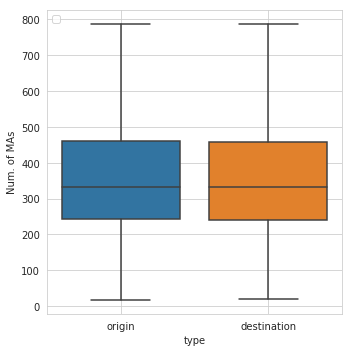

In [70]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax=sns.boxplot(data=connections, x='type', y='n_meaningful_dest', showfliers = False);
ax.set_ylabel("Num. of MAs")
ax.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(os.path.join('figs', 'n_origin_dest.png'))

### Plot number of trips vs population

In [43]:
zones_gdf= gpd.read_file(os.path.join('data','distritos_mitma_pop.geojson'), driver='GeoJSON')
zones_gdf = zones_gdf.set_index('ID')

In [44]:
zones_gdf.head()

,area,POPULATION,geometry
ID,,,
2408910,3.787154e+06,7913.0,"POLYGON ((-617620.363 5250652.172, -617588.265..."
22117_AM,9.454305e+08,4735.0,"POLYGON ((34933.242 5170510.672, 35245.027 516..."
2305009,3.800710e+07,6438.0,"POLYGON ((-422751.792 4546198.978, -422786.882..."
07058_AM,3.860436e+08,5526.0,"POLYGON ((316538.056 4827970.183, 316275.800 4..."
2305006,9.881060e+06,6088.0,"POLYGON ((-422698.978 4547443.296, -422616.243..."


In [45]:
zones_gdf['POPULATION'].mean()

14428.358020231213

In [46]:
sum_od_stacked.head()

num_trips   distance
origen                                 
01001_AM 01002       220.408  46.607889
         01010_AM    113.594  57.622506
         01031_AM    302.246  37.306976
         01036       462.437  52.641754
         01043_AM   3269.559  22.761490

In [47]:
total_per_origin= sum_od_stacked.groupby('origen').sum()
total_per_origin.head()

,num_trips,distance
origen,,
01001_AM,152008.409,1.320149e+06
01002,101424.615,1.342199e+06
01010_AM,77512.456,1.356326e+06
01031_AM,124997.327,1.269780e+06
01036,143797.371,1.363671e+06


In [48]:
total_per_origin.sum()

num_trips    8.304503e+08
distance     4.349058e+09
dtype: float64

In [49]:
total_per_origin['population'] = zones_gdf['POPULATION']

In [50]:
total_per_origin.head()

,num_trips,distance,population
origen,,,
01001_AM,152008.409,1.320149e+06,6400.0
01002,101424.615,1.342199e+06,8875.0
01010_AM,77512.456,1.356326e+06,5056.0
01031_AM,124997.327,1.269780e+06,6505.0
01036,143797.371,1.363671e+06,16083.0


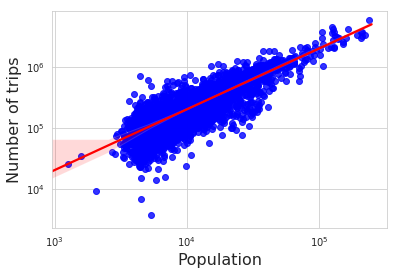

In [51]:
sns.set_style("whitegrid")
ax=sns.regplot(x='population', y='num_trips', 
               data=total_per_origin, 
               scatter_kws={"color": "blue"}, 
               line_kws={"color": "red"});
ax.set(xscale="log", yscale="log")
ax.set_ylabel('Number of trips')
ax.set_xlabel('Population')
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.savefig(os.path.join('figs','population-vs-num_trips.png'))

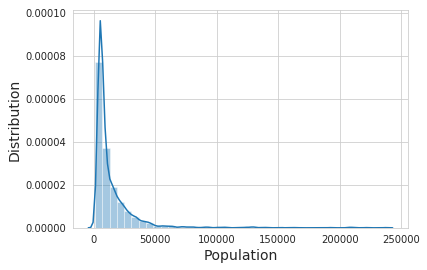

In [52]:
sns.set_style("whitegrid")
ax=sns.distplot(total_per_origin['population'], bins=40, rug=False);
ax.set_ylabel('Distribution')
ax.set_xlabel('Population')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.savefig(os.path.join('figs','population_distribution.png'))

In [53]:
print("That's all folks!")

That's all folks!
